In [1]:
import yfinance as yf
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
import mplfinance as mpf

#### Measuring $\beta$

In [12]:
def beta(ticker, start, end, index = 'VOO', interval = '1mo'):
    '''Return the beta of a stock over a period of time at a monthly interval
    Compared to another index of security'''

    # security 
    df_s = yf.Ticker(ticker).history(start = start, end = end, interval = interval)
    df_s['% change'] = df_s['Close'].pct_change() * 100

    # market/index
    df_index = yf.Ticker(index).history(start = start, end = end,  interval = interval)
    df_index['% change'] = df_index['Close'].pct_change() * 100 

    # remove NaN value at the start date and ensure that shapes are same
    m = min(df_s.shape[0], df_index.shape[0])

    # compute the i = 0, j = 0 element of the covariance matrix and variance of the index
    cov = np.cov(df_s.iloc[1:m]['% change'], df_index.iloc[1:m]['% change'])[0][0]
    var = np.var(df_index.iloc[1:m]['% change'])
    
    return 'Beta of ' + ticker + ' with respsect to ' + index + ': ' + str(round(cov/var, 2))


## example with Nvidia. YTD, there have been lots of fluctuations, w/ the AI bubble 
## and the implications of graphics cards as the foundation of AI
print(beta(ticker = 'NVDA', start = '2024-01-1', end = '2024-05-10', index = 'VOO'))


Beta of NVDA with respsect to VOO: 13.74


#### Portfolio Composition

/var/folders/qc/fc2g0sgj0pzcp12drdrxgt180000gn/T/ipykernel_43843/3403291688.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['Market Value'] = df.apply(lambda row: row['Quantity'] * yf.Ticker(row['Ticker']).history(period='1d')['Close'][0], axis=1)
/var/folders/qc/fc2g0sgj0pzcp12drdrxgt180000gn/T/ipykernel_43843/3403291688.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['Market Value'] = df.apply(lambda row: row['Quantity'] * yf.Ticker(row['Ticker']).history(period='1d')['Close'][0], axis=1)
/var/folders/qc/fc2g0sgj0pzcp12drdrxgt180000gn/T/ipykernel_43843/3403291688.py:7: FutureWarning: Series.__getitem_

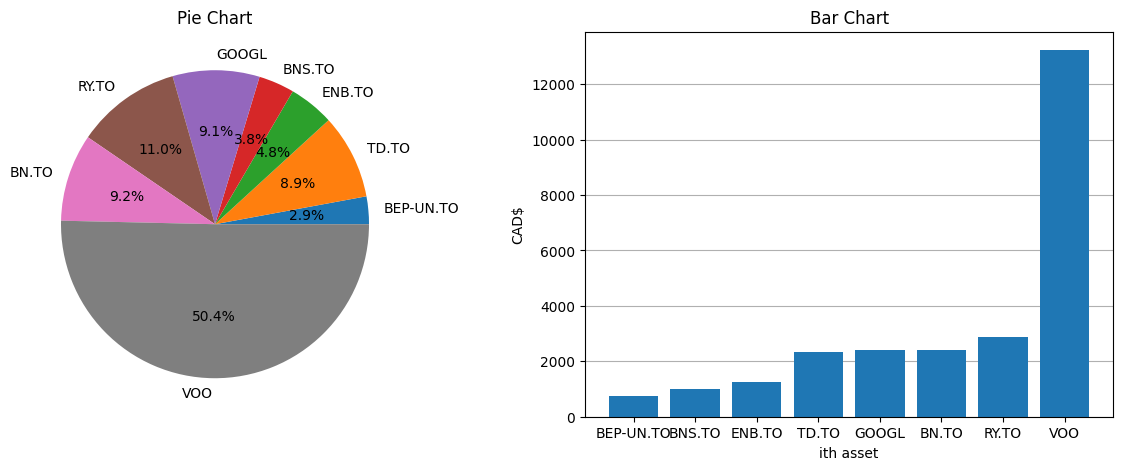

In [17]:
def portfolio_composition(df):
    '''Return a pie and bar chart of the current portfolio'''
    xr = yf.Ticker("USDCAD=X").history(period='1d').iloc[0]['Close'] # define exchange rate

    # find the market values using a lambda function 
    # note: warnings come from lambda function
    df['Market Value'] = df.apply(lambda row: row['Quantity'] * yf.Ticker(row['Ticker']).history(period='1d')['Close'][0], axis=1)
    df['Market Value'] = np.where(df['Currency'] == 'USD', df['Market Value'] * xr, df['Market Value'])
    
    # normalize individual market values 
    df['% Contribution'] = df['Market Value']/sum(df['Market Value'])

    # set up the pie chart
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    ax[0].pie(df['% Contribution'], labels = df['Ticker'], autopct = '%1.1f%%', radius=1)
    ax[0].set_title('Pie Chart') # use set_title() for subplots, not just title()

    # set up the histogram 
    df= df.sort_values('Market Value')
    ax[1].bar(df['Ticker'], df['Market Value']) 
    ax[1].set_title('Bar Chart')
    ax[1].set_xlabel('ith asset')
    ax[1].set_ylabel('CAD$')
    ax[1].grid(axis = 'y')
    ax[1].set_axisbelow(True) # grid lines are behind the bars


## example call with a theoretical portfolio consisting, primarily of blue chip TSX stocks
## and some S&P 500 index
df = pd.DataFrame({ 'Quantity' :  [20, 30, 25, 15, 10, 20, 40, 20], 'Ticker' : ['BEP-UN.TO', 'TD.TO', 'ENB.TO', 'BNS.TO', 'GOOGL', 'RY.TO', 'BN.TO', 'VOO'], 'Currency' : ['CAD', 'CAD', 'CAD', 'CAD', 'USD', 'CAD', 'CAD', 'USD']}  )
portfolio_composition(df)

#### Portfolio Returns

In [80]:
def portfolio_returns(tickers, quantities, interval):
    '''Print out the portfolio returns of some theoretical portolio'''
    df_close = yf.download(tickers, period=interval, group_by='tickers')
    df_close = df_close.xs('Close', level=1, axis=1)

    df_close = df_close.mul(pd.Series(quantities), axis = 1 )
    df_close['Portfolio Value'] = df_close.sum(axis=1)


    new = df_close[['Portfolio Value']]

    new['Percent Change'] = new['Portfolio Value'].pct_change() * 100

    print(new)
    print('\n')
    print('High: ', new['Portfolio Value'].idxmax() , max(new['Portfolio Value']))
    print('Low:  ', new['Portfolio Value'].idxmin(), min(new['Portfolio Value']) )


tickers = 'BEP-UN.TO TD.TO ENB.TO BNS.TO GOOGL RY.TO BN.TO VOO'
xr = yf.Ticker("USDCAD=X").history(period='1d').iloc[0]['Close']
quantities = {
    'BEP-UN.TO': 10,
    'TD.TO': 30,
    'ENB.TO': 25,
    'BNS.TO': 10,
    'GOOGL': 10 *xr,
    'RY.TO': 20,
    'BN.TO': 50,
    'VOO': 15 *xr
}


## example call with a theoretical portfolio
portfolio_returns(tickers, quantities,'5d')

[*********************100%%**********************]  8 of 8 completed

            Portfolio Value  Percent Change
Date                                       
2024-05-13     22590.887916             NaN
2024-05-14     22634.254072        0.191963
2024-05-15     22826.849714        0.850903
2024-05-16     22828.542247        0.007415
2024-05-17     22854.059742        0.111779


High:  2024-05-17 00:00:00 22854.05974206449
Low:   2024-05-13 00:00:00 22590.887915829226



/var/folders/qc/fc2g0sgj0pzcp12drdrxgt180000gn/T/ipykernel_43843/3989031150.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new['Percent Change'] = new['Portfolio Value'].pct_change() * 100


#### Expected Returns and Variances

In [81]:
def expected_return(ticker, start, end, interval = '1mo'):
    '''Return the expected return of a stock over a 1mo standard interval'''

    # security of interest
    df_s = yf.Ticker(ticker).history(start = start, end = end, interval = interval)
    df_s['% change'] = df_s['Close'].pct_change() * 100
    expected_s = sum(df_s['% change'][1:])/df_s.shape[0]
    var_s = np.var(df_s['% change'][1:])
    return expected_s, var_s



df_tickers = pd.DataFrame({'Ticker': ['BEP-UN.TO', 'TD.TO', 'ENB.TO', 'BNS.TO', 'GOOGL', 'RY.TO', 'BN.TO', 'VOO']})
df_tickers['Expected Return'] = pd.NA
df_tickers['Variance'] = pd.NA

start = '2023-05-15'
end = '2024-05-15'

for i in range(df_tickers.shape[0]): 
    ex, var = expected_return(df_tickers['Ticker'][i], start, end)
    df_tickers['Expected Return'][i] = ex
    df_tickers['Variance'][i] = var
    
print(df_tickers)


/var/folders/qc/fc2g0sgj0pzcp12drdrxgt180000gn/T/ipykernel_43843/3160267215.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_tickers['Expected Return'][i] = ex
/var/folders/qc/fc2g0sgj0pzcp12drdrxgt180000gn/T/ipykernel_43843/316026721

      Ticker Expected Return    Variance
0  BEP-UN.TO        0.482236  166.106151
1      TD.TO       -0.108075   16.074936
2     ENB.TO        0.667814    11.31827
3     BNS.TO        1.055613   32.619231
4      GOOGL         3.29937   26.676218
5      RY.TO        1.634235   37.265461
6      BN.TO        2.848494   53.432137
7        VOO        1.690241   17.401823


/var/folders/qc/fc2g0sgj0pzcp12drdrxgt180000gn/T/ipykernel_43843/3160267215.py:22: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_tickers['Expected Return'][i] = ex
/var/folders/qc/fc2g0sgj0pzcp12drdrxgt180000gn/T/ipykernel_43843/316026721

#### SMA plotting (First Principles)

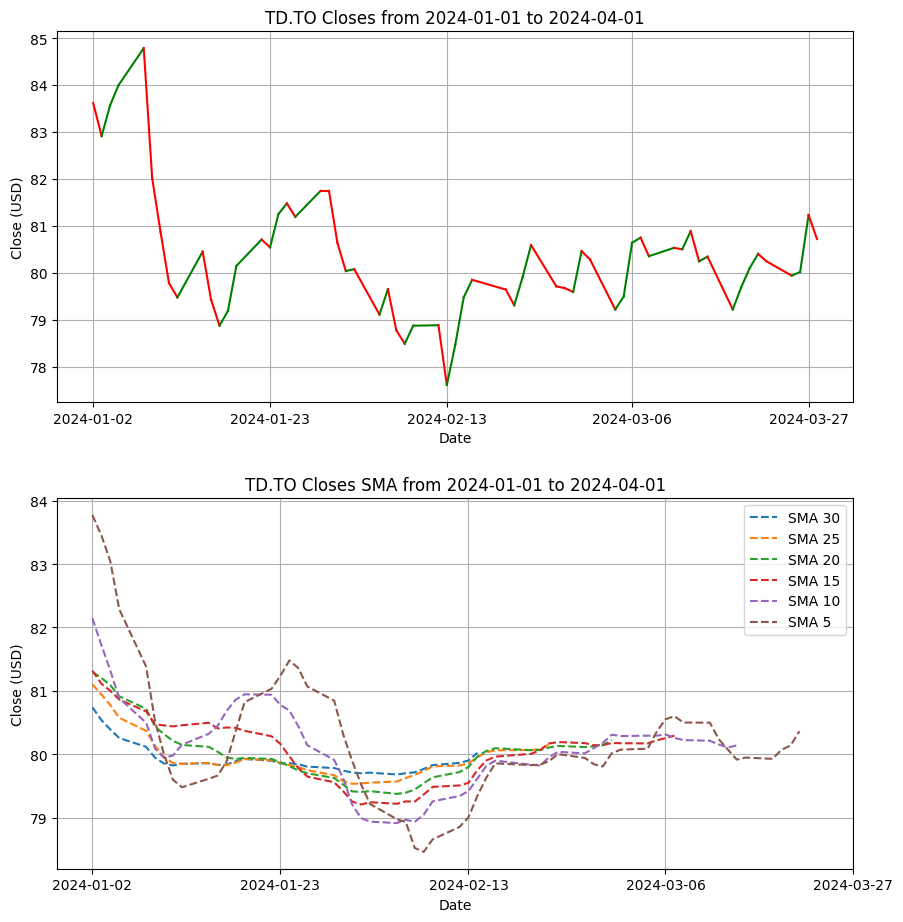

In [73]:
def plot_sma(x, y, n, m, axs):
    '''Plotting helper function'''
    y_sma = []
    for i in range(m - n):
        y_sma.append(sum(y[i:i + n]) / n)
    axs[1].plot(x[:len(y_sma)], y_sma, '--', label=f'SMA {n}')
    axs[1].legend()

def my_SMA(ticker, start, end,  smas = [30, 20, 10, 5]):
    '''Plot two graphs, one with P/L and one with SMA defined by the user'''
    df = yf.Ticker(ticker).history(start =start, end = end, interval = '1d')

    # define number of rows
    m = df.shape[0]
    closing = df['Close']
    fig, axs = plt.subplots(2, figsize=(10, 10))

    # get times for x-axis
    times = df.index

    # Determine if closing price is increasing or decreasing
    # is_inc = [closing.iloc[i] <= closing.iloc[i + 1] for i in range(m - 1)]
    # print(is_inc)

    # Plot price changes
    for i in range(m - 1):
        x = [times[i], times[i + 1]]
        y = [closing.iloc[i], closing.iloc[i + 1]]
        if y[0] < y[1]:  # increasing
            axs[0].plot(x, y, 'g-')
        else:  # decreasing
            axs[0].plot(x, y, 'r-')

    # Plot SMA
    for sma in smas:
        plot_sma(times, closing, sma, m, axs)
        
    # Formatting
    fig.tight_layout(pad=5.0)
    for ax in axs.flat:
        ax.set_xticks(times[::15])
        ax.set_xlabel('Date')
        ax.set_ylabel('Close (USD)')
        ax.grid()

    axs[0].set_title(ticker + ' Closes from ' + start + ' to ' + end)
    axs[1].set_title(ticker + ' Closes SMA from ' + start + ' to ' + end)
    return plt.show()

## example call with TD.TO YTF, using an array of simple moving average window sizes
my_SMA(ticker = 'TD.TO', start ='2024-01-01', end=  '2024-04-01', smas= [30,25,20,15,10,5])

#### Candlestick plotting (First Principles)

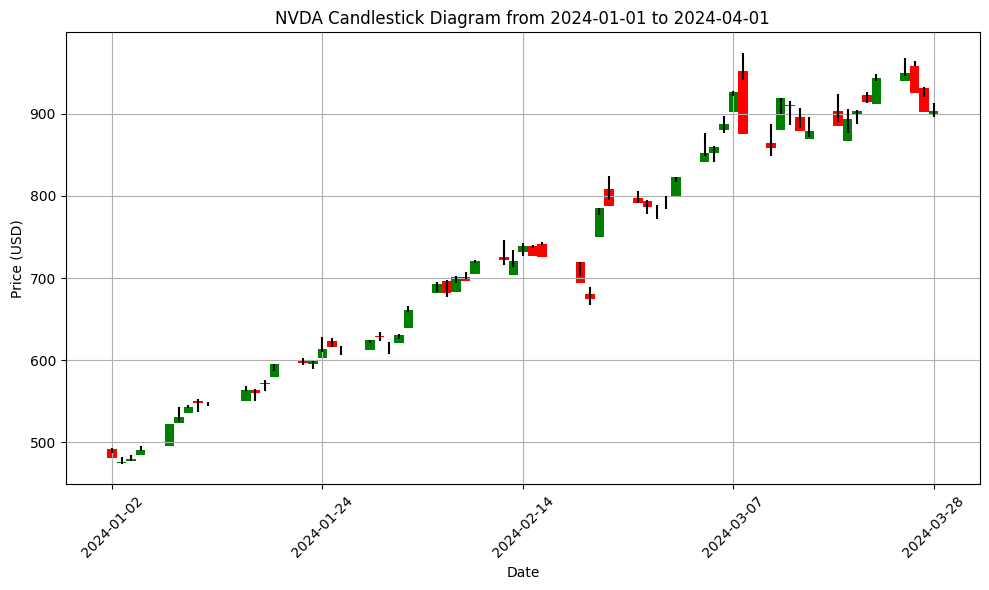

In [74]:
def my_candlestick(ticker, start, end):
    '''Plot a candlestick diagram (OHLC) from a start to end date for a given stock'''
    df = yf.Ticker(ticker).history(start =start, end = end, interval = '1d')

    # define number of rows and columns
    m = df.shape[0]

    # get the necessary price columns
    open_price = df['Open']
    close_price = df['Close']
    high_price = df['High']
    low_price = df['Low']

    # plotting setup
    fig, ax = plt.subplots(figsize=(10, 6))

    # get times for x-axis
    times = df.index

    # plot candlestick bars
    for i in range(m):
        if close_price.iloc[i] > open_price.iloc[i]:  # green increase
            ax.bar(x=times[i], height=close_price.iloc[i] - open_price.iloc[i], width=1,
                bottom=open_price.iloc[i], yerr=[[open_price.iloc[i] - low_price.iloc[i]], [high_price.iloc[i] - close_price.iloc[i]]],
                color='g')
        else:  # red decrease
            ax.bar(x=times[i], height=open_price.iloc[i] - close_price.iloc[i], width=1,
                bottom=close_price.iloc[i], yerr=[[close_price.iloc[i] - low_price.iloc[i]], [high_price.iloc[i] - open_price.iloc[i]]],
                color='r')

    # formatting
    ax.set_title(ticker + ' Candlestick Diagram from ' + start + ' to ' + end)
    ax.set_xticks(times[::15])
    ax.set_xlabel('Date')
    ax.set_ylabel('Price (USD)')
    ax.grid()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


## example call with NVDA 
my_candlestick(ticker = 'NVDA', start ='2024-01-01', end=  '2024-04-01')


#### Candlestick Plotting with mpfinance (SO MUCH EASIER)

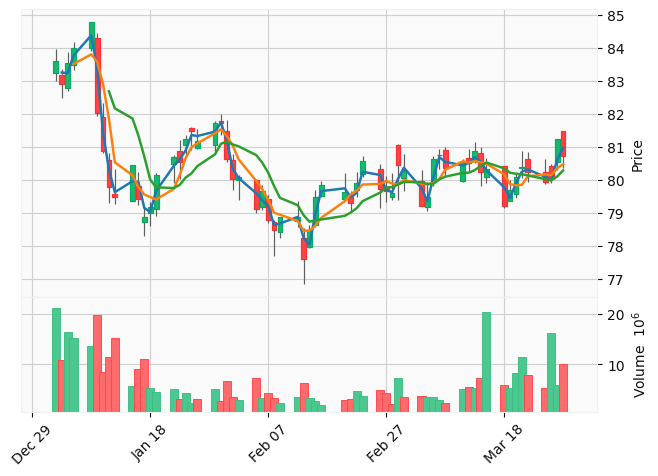

In [77]:
df = yf.Ticker('TD.TO').history(start = '2024-01-01', end = '2024-04-01')
df.head()
mpf.plot(df, type='candle', mav = (2, 4, 8), volume = True, show_nontrading = True, style ='yahoo')

## note you can show_nontrading (weekends + holidays)